In [64]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import optuna
import time
import numpy as np

In [44]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Used device: {device}")

Used device: mps


In [45]:
df = pd.read_csv("movies_dataset.csv")
x = df[["user_id", "movie_id"]]
y = df["rating"]

X_f, X_test, y_f, y_test = train_test_split(
    x, y, test_size=0.15, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_f, y_f, test_size=0.12, random_state=42
)

### Baseline - average of ratings

In [46]:
average_rating = df["rating"].mean()
y_pred_baseline = [average_rating] * len(y_test)
baseline_mse = mean_squared_error(y_test, y_pred_baseline)

print(f"Ratings average global: {average_rating:.2f}")
print(f"Baseline mse: {baseline_mse:.4f}")

Ratings average global: 3.50
Baseline mse: 1.1329


### Neural Network

using pytorch Dataset to create custom dataset for neural network and DataLoaders

In [47]:
class MovieDataset(Dataset):
    def __init__(self, df, targets):
        self.users = torch.tensor(df["user_id"].values, dtype=torch.long)
        self.movies = torch.tensor(df["movie_id"].values, dtype=torch.long)
        self.ratings = torch.tensor(targets.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, index):
        return self.users[index], self.movies[index], self.ratings[index]

In [48]:
train_set = MovieDataset(X_train, y_train)
valid_set = MovieDataset(X_valid, y_valid)
test_set = MovieDataset(X_test, y_test)

In [49]:
BATCH_SIZE = 1024
torch.manual_seed(42)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    pin_memory=True
)

valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, pin_memory=True)

Model architecture

In [50]:
class Recommender(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim=32, dropout_rate=0.4):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.SiLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1)
        )

        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.movie_embedding.weight)
    
    def forward(self, user, movie):
        user_vector = self.user_embedding(user)
        movie_vector = self.movie_embedding(movie)
        x = torch.cat([user_vector, movie_vector], dim=-1)
        return self.mlp(x).squeeze()

In [51]:
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()

train model and find hyperparameters using optuna

In [52]:
def objective(trial):
    emb_dim = trial.suggest_categorical("embedding_dim", [16, 32, 64, 128])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = Recommender(n_users, n_movies, emb_dim, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    n_epochs = 5

    for epoch in range(n_epochs):
        model.train()
        for users, movies, ratings in train_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            optimizer.zero_grad()
            pred = model(users, movies)
            loss = criterion(pred, ratings)
            loss.backward()
            optimizer.step()
        
        model.eval()
        valid_mse = 0
        with torch.inference_mode():
            for users, movies, ratings in valid_loader:
                users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
                preds = model(users, movies)
                valid_mse += criterion(preds, ratings).item()
        
        avg_valid_mse = valid_mse / len(valid_loader)

        trial.report(avg_valid_mse, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return avg_valid_mse

In [53]:
torch.manual_seed(42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    direction="minimize",
    sampler=sampler,
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=30)

[I 2026-01-28 12:33:48,440] A new study created in memory with name: no-name-a4faea53-b0ea-4e4a-8a2e-f35e09dc023f
[I 2026-01-28 12:34:17,697] Trial 0 finished with value: 0.8855315947532654 and parameters: {'embedding_dim': 32, 'lr': 0.0002051338263087451, 'dropout': 0.16239780813448107}. Best is trial 0 with value: 0.8855315947532654.
[I 2026-01-28 12:34:46,881] Trial 1 finished with value: 0.8857788437604904 and parameters: {'embedding_dim': 32, 'lr': 0.00010994335574766199, 'dropout': 0.4879639408647978}. Best is trial 0 with value: 0.8855315947532654.
[I 2026-01-28 12:35:16,432] Trial 2 finished with value: 0.844100107550621 and parameters: {'embedding_dim': 16, 'lr': 0.0004059611610484307, 'dropout': 0.30990257265289517}. Best is trial 2 with value: 0.844100107550621.
[I 2026-01-28 12:35:54,064] Trial 3 finished with value: 0.8464377504587174 and parameters: {'embedding_dim': 64, 'lr': 0.0003839629299804173, 'dropout': 0.2465447373174767}. Best is trial 2 with value: 0.84410010755

### Train model more thouroughly on the best params found

In [54]:
# evaluate model function

def evaluate_tm(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    with torch.inference_mode():
        for users, movies, ratings in data_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            y_pred = model(users, movies)
            loss = loss_fn(y_pred, ratings)
            total_loss += loss.item()
    
    return total_loss / len(data_loader)

In [ ]:
# training loop

def train_with_early_stopping(model, optimizer, loss_fn, train_loader,
                              valid_loader, n_epochs, patience=10):
    history = {"train_losses": [], "valid_losses": []}
    best_valid_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        total_loss = 0.0
        model.train()
        t0 = time.time()

        for users, movies, ratings in train_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            optimizer.zero_grad()
            y_pred = model(users, movies)
            loss = loss_fn(y_pred, ratings)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_valid_loss = evaluate_tm(model, valid_loader, loss_fn)

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), "best_model_tmp.pth")
            best = " (best)"
            patience_counter = 0
        else:
            patience_counter += 1
            best = ""
        
        t1 = time.time()
        history["train_losses"].append(avg_train_loss)
        history["valid_losses"].append(avg_valid_loss)

        print(f"Epoch {epoch + 1}/{n_epochs} | "
              f"Train MSE: {avg_train_loss:.4f} | "
              f"Valid MSE: {avg_valid_loss:.4f}{best} | "
              f"Time: {t1 - t0:.1f}s")

        if patience_counter >= patience:
            print("Early stopping")
            model.load_state_dict(torch.load("best_model_tmp.pth", weights_only=True))
            break
    
    return history

In [56]:
def plot_train_valid_loss(history):
    epochs = range(1, len(history["train_losses"]) + 1)
    plt.figure(figsize=(10, 7))
    plt.plot(epochs, history["train_losses"], "bo-", label="training")
    plt.plot(epochs, history["valid_losses"], "ro-", label="validation")

    plt.title("Training vs validation loss")
    plt.xlabel("epoch")
    plt.ylabel("loss value")
    plt.legend()
    plt.grid()
    plt.show()

In [57]:
params = study.best_params

print(f"Best learning rate: {params['lr']}")
print(f"Best dropout: {params['dropout']}")
print(f"Best embedding dimension: {params['embedding_dim']}")

Best learning rate: 0.004941429387696322
Best dropout: 0.14489260491655787
Best embedding dimension: 64


In [59]:
final_recommender = Recommender(
    n_users, n_movies,
    embedding_dim=params["embedding_dim"],
    dropout_rate=params["dropout"]
).to(device)

optimizer = torch.optim.Adam(final_recommender.parameters(), lr=params["lr"], weight_decay=1e-4)
criterion = nn.MSELoss()

In [60]:
torch.manual_seed(42)

n_epochs = 100
history = train_with_early_stopping(
    final_recommender, 
    optimizer,
    criterion,
    train_loader,
    valid_loader,
    n_epochs,
    patience=10
)

Epoch 1/100 | Train MSE: 1.1372 | Valid MSE: 0.8550 (best) | Time: 12.9s
Epoch 2/100 | Train MSE: 0.8628 | Valid MSE: 0.8351 (best) | Time: 12.6s
Epoch 3/100 | Train MSE: 0.8169 | Valid MSE: 0.8178 (best) | Time: 12.8s
Epoch 4/100 | Train MSE: 0.7801 | Valid MSE: 0.8093 (best) | Time: 12.7s
Epoch 5/100 | Train MSE: 0.7535 | Valid MSE: 0.8046 (best) | Time: 12.6s
Epoch 6/100 | Train MSE: 0.7374 | Valid MSE: 0.8058 | Time: 12.7s
Epoch 7/100 | Train MSE: 0.7258 | Valid MSE: 0.8024 (best) | Time: 12.7s
Epoch 8/100 | Train MSE: 0.7189 | Valid MSE: 0.7986 (best) | Time: 13.1s
Epoch 9/100 | Train MSE: 0.7136 | Valid MSE: 0.7995 | Time: 13.3s
Epoch 10/100 | Train MSE: 0.7101 | Valid MSE: 0.7984 (best) | Time: 13.2s
Epoch 11/100 | Train MSE: 0.7060 | Valid MSE: 0.7980 (best) | Time: 13.2s
Epoch 12/100 | Train MSE: 0.7025 | Valid MSE: 0.8002 | Time: 12.9s
Epoch 13/100 | Train MSE: 0.6990 | Valid MSE: 0.8016 | Time: 12.6s
Epoch 14/100 | Train MSE: 0.6965 | Valid MSE: 0.8017 | Time: 12.6s
Epoch 15

/var/folders/9w/pb6mlr6d24s06b6lfpymf__80000gn/T/ipykernel_75876/2185236908.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model

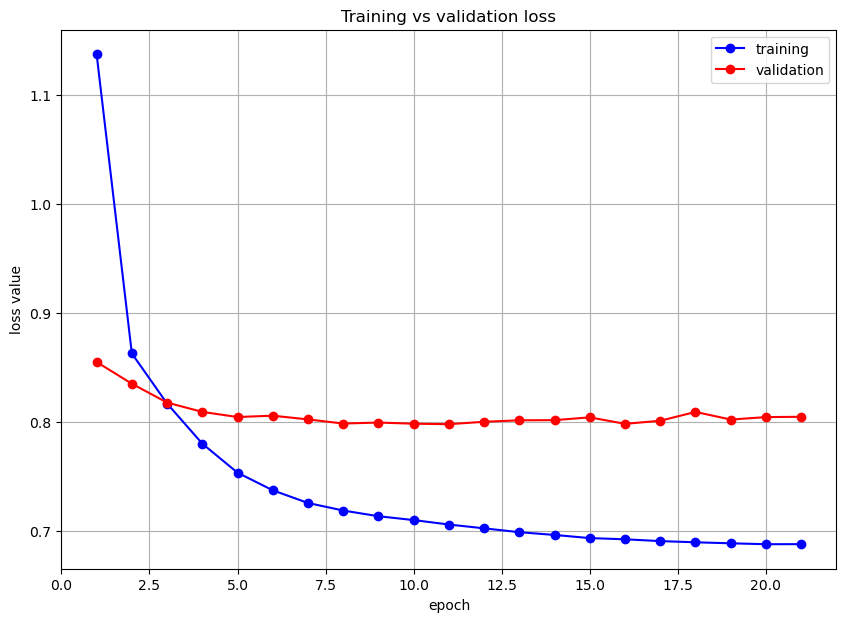

In [61]:
plot_train_valid_loss(history)

### Save final model and embeddings

In [65]:
torch.save(final_recommender.state_dict(), "best_model_th.pth")

movie_embd = final_recommender.movie_embedding.weight.detach().cpu().numpy()
np.save("movie_embeddings.npy", movie_embd)

all_movie_ids = sorted(df['movie_id'].unique())
np.save("movie_ids_map.npy", np.array(all_movie_ids))